In [1]:
import cv2
from PIL import Image
import clip
import torch
import plotly.express as px
import datetime
from IPython.core.display import HTML
import matplotlib.pyplot as plt

In [2]:
all_task = './examples/full.mp4'
device = "cuda"
model, preprocess = clip.load("ViT-B/32")

In [13]:
class Embeddings:
    def __init__(self, prompt, plot=True, show_frames=False, friend_frames=1):
        self.prompt = prompt
        self.plot = plot
        self.show_frames = show_frames
        self.friend_frames = friend_frames
        self.frames = []
        video_cv2 = cv2.VideoCapture(all_task)
        frame_cv2 = video_cv2.get(cv2.CAP_PROP_FPS)
        current_frame = 0
        while video_cv2.isOpened():
            ret, frame = video_cv2.read()
            if ret == True:
                self.frames.append(Image.fromarray(frame[:, :, ::-1]))
            else:
                break
            current_frame += 1
            video_cv2.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

        print(f"Frames extracted: {len(self.frames)}")
        
        image_input = torch.stack([preprocess(frame) for frame in self.frames]).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        with torch.no_grad():
            text_features = model.encode_text(clip.tokenize(prompt).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
        print(f"Image Features: {image_features.shape}")
        print(f"Text Features: {text_features.shape}")

        similarity = (100.0 * image_features @ text_features.T)
        top_frames, index_frame = similarity.topk(k=friend_frames, largest=True)
        if plot:
            fig = px.imshow(similarity.T.cpu().numpy(),
                            aspect='auto', color_continuous_scale='viridis')
            fig.update_layout(coloraxis_showscale=False)
            fig.update_xaxes(showticklabels=True)
            fig.update_yaxes(showticklabels=False)
            fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
            fig.show()
            print()
            plt.figure(figsize=(20, 10))
            plt.plot(similarity.cpu().numpy())

        if show_frames:
            for i in index_frame:
                display(self.frames[i])
                print("Matching frame:", self.frames[index_frame[i]])
                seconds = round(i.cpu().numpy()[0] * 1 / frame_cv2)
                print('seconds:', seconds)
                display(HTML(
                    f"{str(datetime.timedelta(seconds=seconds))} (<a target=\"_blank\" &t={seconds}\">link</a>)"))


In [14]:
saving_frames = Embeddings(prompt='open the upper cabinet', plot=True, show_frames=True, friend_frames=1)

Frames extracted: 533


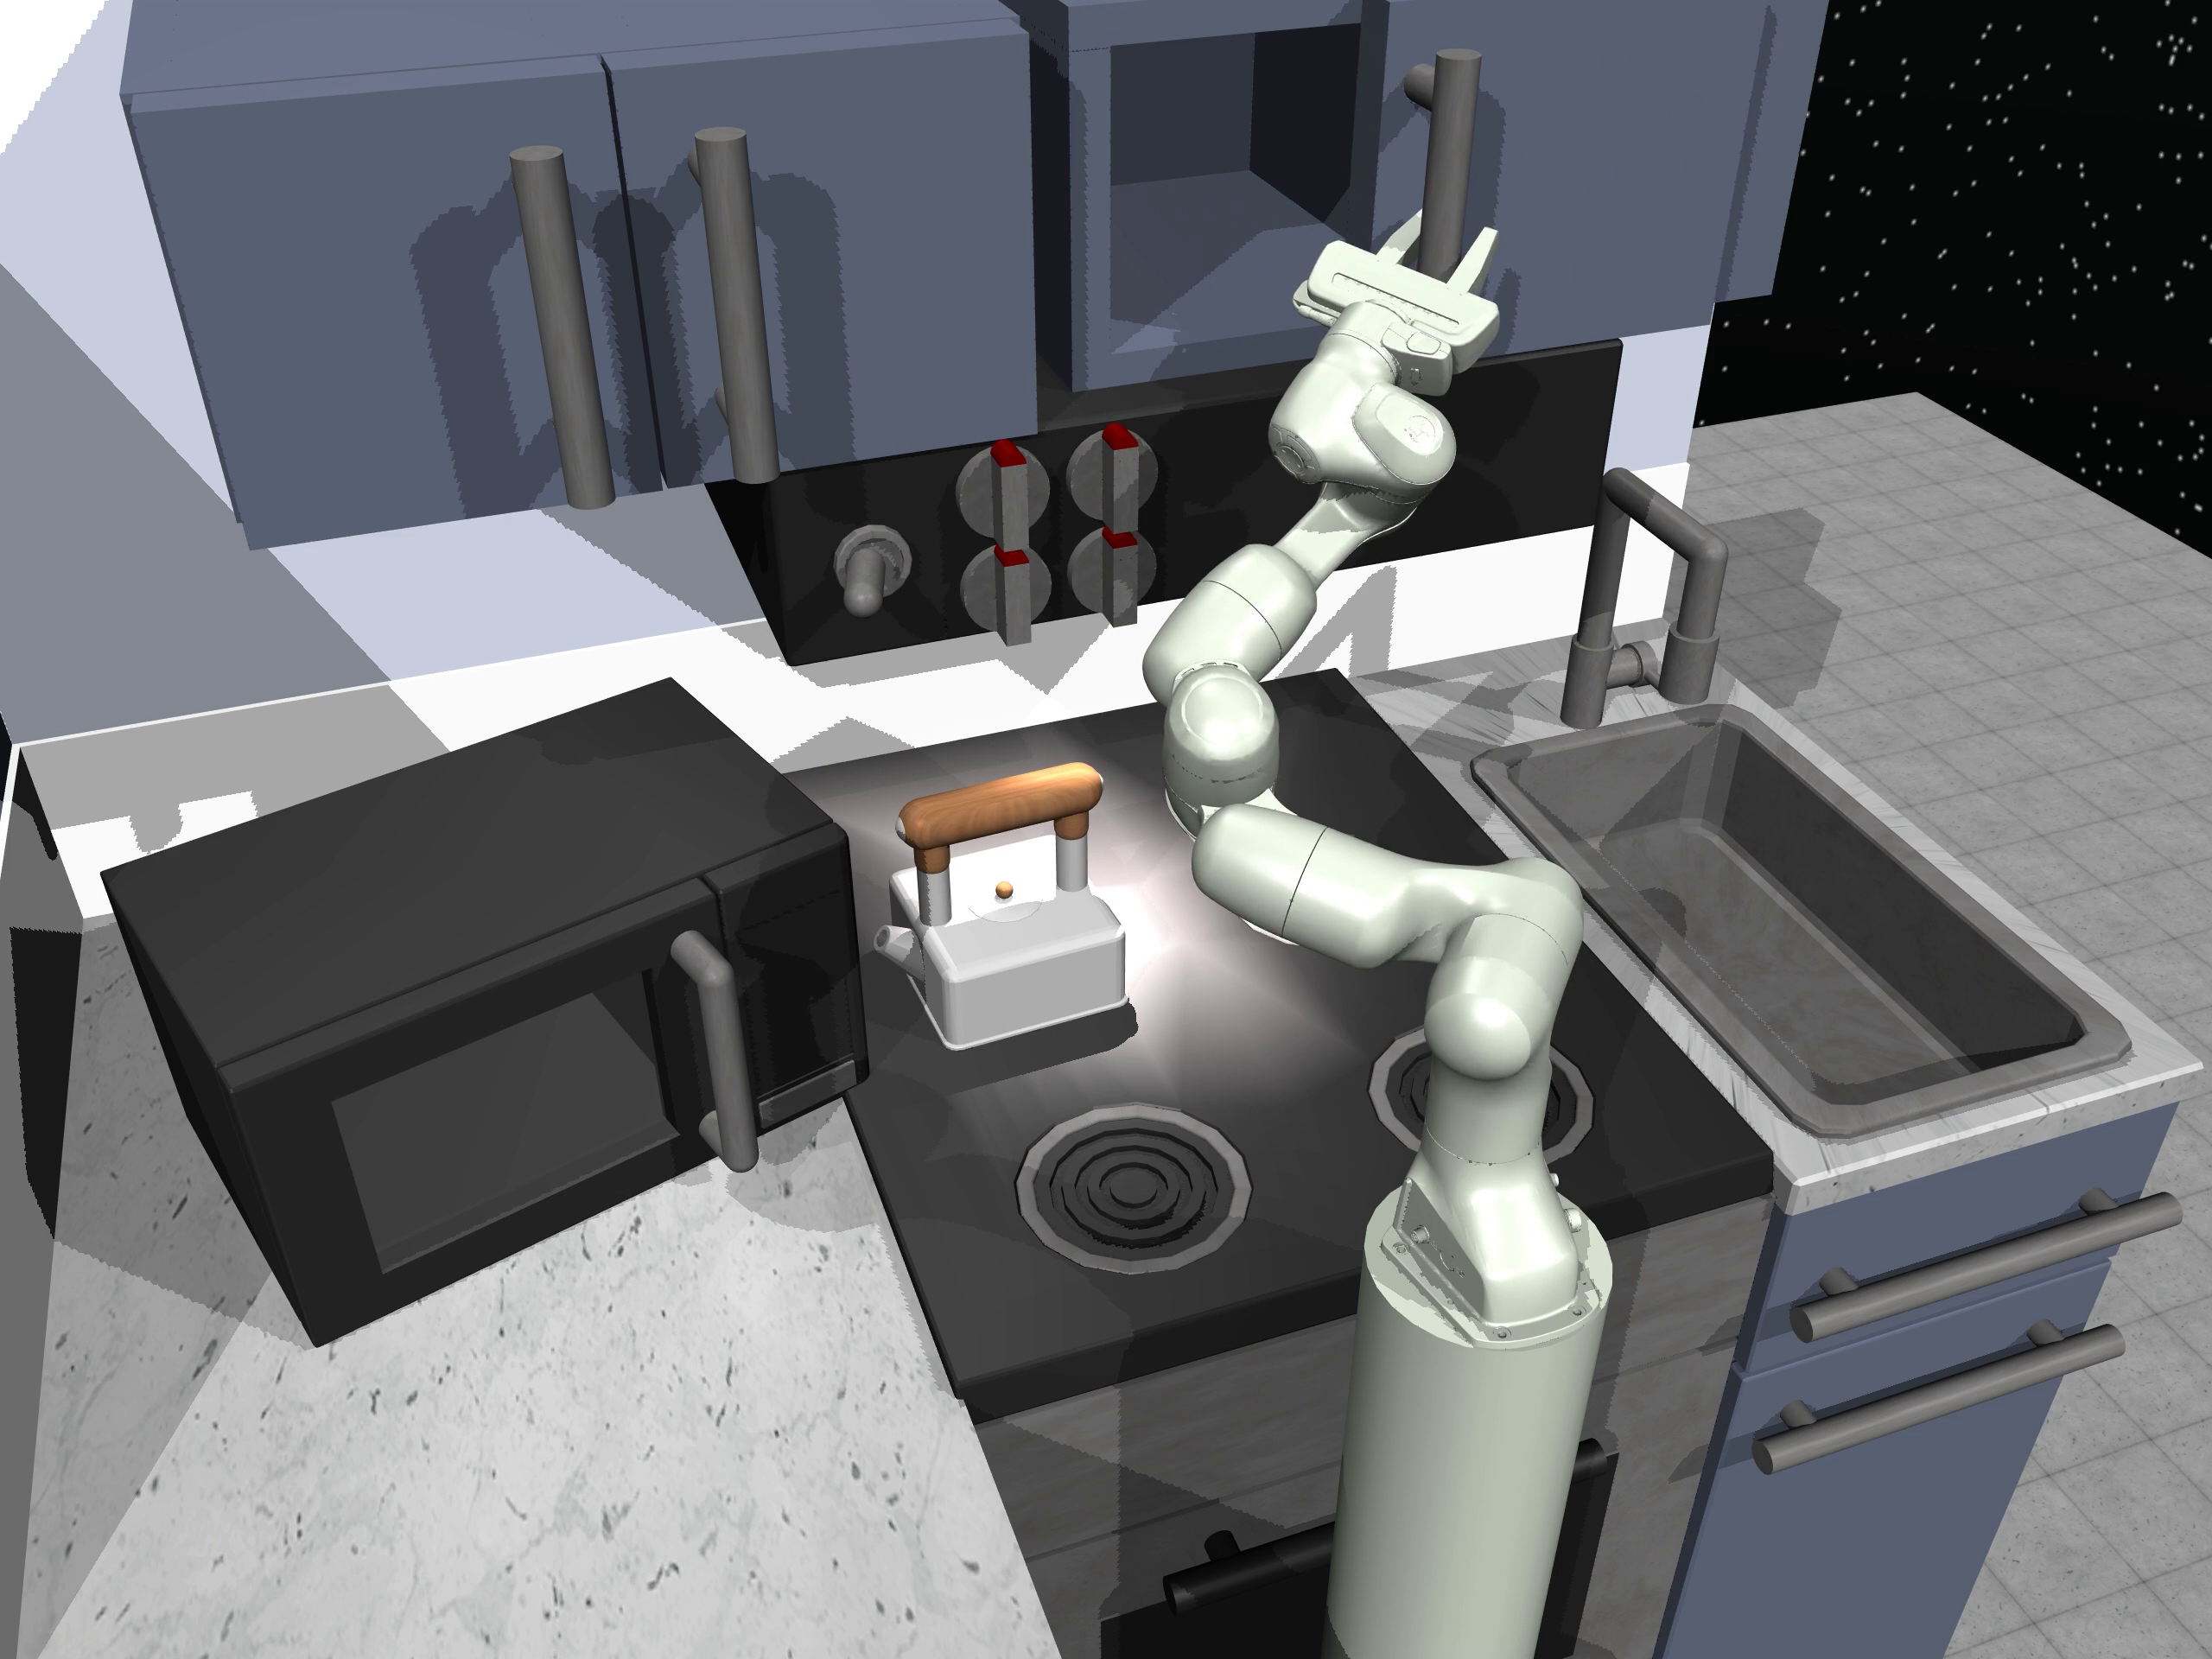

In [13]:
saving_frames.frames[433]